In [1]:
import numpy as np
import pandas as pd
import os

from fastai.text import *
from fastai import *

In [2]:
path = Path('/home/jupyter/insight_project/basilica-insight-project/data/csv')

In [3]:
filenames = path.ls()
len(filenames)

72

In [4]:
#Uncomment if first time run this notebook

# dfs = []
# for file in filenames:
#     if file.name == 'models': pass
#     df = pd.read_csv(file)
#     dfs.append(df)

# df_total = pd.concat(dfs)

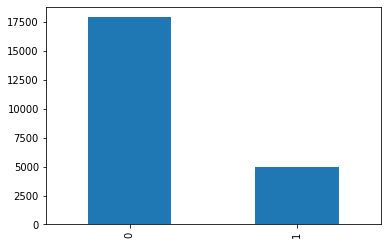

In [5]:
df_total['Label'].value_counts().plot(kind='bar')

In [6]:
data_lm = (TextList
           .from_df(df_total,path=path)
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=64,num_workers=16)
          )

In [13]:
!rm -rf {path}/data_lm.pkl

In [11]:
data_lm.save(path/'models/data_lm.pkl')

In [ ]:
data_lm = load_data(path,'data_lm.pkl',bs=64)

In [7]:
data_lm.show_batch()

idx,text
0,xxmaj fun and xxmaj memorable first xxmaj date xxmaj idea xxunk ? \n \n xxmaj the 😋 mcdonald xxunk xxunk xxmaj date 🍦 \n xxmaj the xxunk xxmaj drive - in 🙈 xxmaj movie 📽 xxmaj date xxunk 🏽 \n xxmaj the 🥵 xxmaj xxunk xxunk 💋 xxmaj date 😳 \n xxmaj the purchasing me xxunk a firearm under your name xxmaj date \n xxmaj
1,"no incentive to take large or long orders . \n * xxmaj you can not unassign orders on your own after accepting but before picking up food . xxmaj you have to contact support and if you try to unassign over 5 minutes after accepting you are "" in violation of your contract . "" \n * xxmaj the timer for unavailable customers is 10 minutes which seems"
2,question went unanswered ? \n \n # # # xxmaj write your question in the comments \n \n \n xxrep 19 - \n \n * * xxmaj useful xxmaj links * * \n \n * [ xxmaj official xxup hp : xxup wu xxmaj blog](https : / / xxunk / posts / ) \n \n * [ xxmaj niantic xxmaj support](https : / / twitter.com
3,"/ / t.co / xxunk xxbos xxunk i get that feeling often , yeah , that people are n't interested in me for other reasons . i do n't think it 's that people find you xxunk , though . xxmaj it 's just that we all in this community run the risk of xxunk on kink . xxbos xxup osha 's xxmaj website - https : / / t.co"
4,def not genius ) . xxmaj markets have a way to humble you . xxbos i just found another job . xxmaj it took about 6 weeks . xxmaj the startup paid exceptionally well . i think i came thru the whole thing quite well . xxmaj stock options were worth less than toilet paper however . xxbos “ xxmaj these reductions are largely unrelated to the overhaul that xxmaj


In [46]:
learn = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.3)

In [17]:
learn.to_fp16()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02
Min loss divided by 10: 1.74E-02


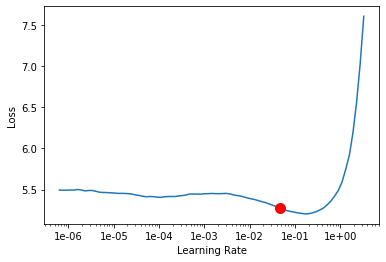

In [18]:
learn.recorder.plot(suggestion=True)

In [19]:
learn.fit_one_cycle(1,1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.079919,3.735755,0.342323,01:53


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


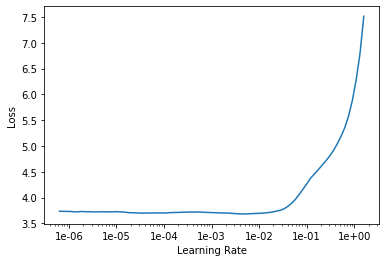

In [20]:
learn.save('1a')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

Min numerical gradient: 1.45E-05
Min loss divided by 10: 5.25E-04


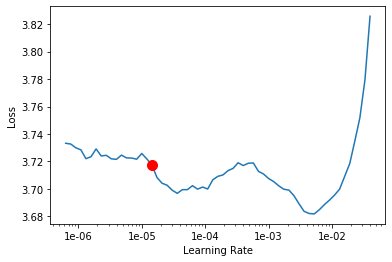

In [22]:
learn.recorder.plot(suggestion=True, skip_end=25)

In [23]:
learn.fit_one_cycle(10,5e-4,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.581583,3.624193,0.357513,02:16
1,3.428341,3.503608,0.376769,02:19
2,3.227065,3.410430,0.394265,02:18
3,3.022787,3.341191,0.405663,02:19
4,2.962931,3.304924,0.413136,02:19
5,2.774968,3.283106,0.419156,02:20
6,2.782223,3.271187,0.422557,02:19
7,2.547405,3.265389,0.424603,02:19
8,2.495533,3.270466,0.425140,02:19
9,2.449748,3.270294,0.425608,02:19


In [24]:
learn.save('fine-tuned-fwd')

In [50]:
path

PosixPath('/home/jupyter/insight_project/basilica-insight-project/data/csv')

In [51]:
learn.save(path/'models/fine-tuned-fwd',with_opt=False)

In [25]:
TEXT = "The AWS"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The AWS Cloud Security Guide For Security - https : / / t.co / @capterra https : / / t.co / AWS xxbos Elastic is now hiring ! Looking for a Open
The AWS Cloud Security Checklist ( MPLS ) Network Research for 2019 - 11 - 19   / 2019 - 07 - 27 Amazon Web Services 2019 Best Practices for


# Build a classifier on 70% of the datasets

In [4]:
filenames.remove(Path('/home/jupyter/insight_project/basilica-insight-project/data/csv/models'))

In [5]:
len(filenames)

71

In [6]:
import random

random.seed(42)
random.shuffle(filenames)

In [7]:
#export 
def _train_valid_split(total_filenames,train_pct=0.7):
    '''split the train and test base on total datasets
        return train_list and valid_list with their associated path'''

    split_point = round(len(total_filenames)*train_pct)
    assert (type(split_point) == int)
    return total_filenames[:split_point],total_filenames[split_point:]

In [8]:
train_list, valid_list = _train_valid_split(filenames)

In [9]:
len(train_list), len(valid_list)

(50, 21)

In [10]:
#export 
def _get_df_from_filenames(filenames):
    '''pass a list of filenames, return df of total'''
    
    dfs = []
    for file in filenames:
        df = pd.read_csv(file)
        dfs.append(df)

    df_total = pd.concat(dfs)
    return df_total

In [11]:
df_train = _get_df_from_filenames(train_list)

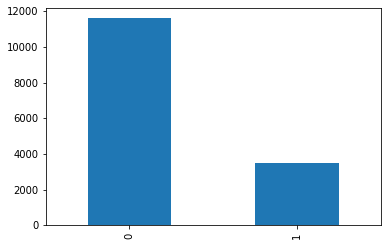

In [12]:
df_train['Label'].value_counts().plot(kind='bar')

In [13]:
df_train['Label'].value_counts()

0    11599
1     3472
Name: Label, dtype: int64

In [14]:
11599 / (11599+3472) #accuracy not higher than this is random guessing...

0.7696237807710172

In [13]:
df_train.head()

,Body,Label,Source
0,Democratizing data analysis with #Google #BigQ...,0,twitter
1,Snowflake: the details of our first Data Wareh...,0,reddit
2,Things I should be doing: scheduling time with...,1,twitter
3,"Another hot day, what to do? Oh yes, I know. E...",1,twitter
4,BigQuery and Data Studio for Model Monitoring ...,0,twitter


In [14]:
len(df_train['Body'].unique())

14207

In [15]:
df_train.shape

(15071, 3)

# check for duplicates

The duplicates with all same labels are fine, the one that with same body but different labels are the problematic ones

In [53]:
df_train_duplicates = df_train[df_train.duplicated(['Body'])].copy()

In [55]:
df_train_duplicates['count'] = df_train_duplicates.groupby('Body')['Body'].transform('count')

In [60]:
np.sort(df_train_duplicates['count'].unique())

array([ 1,  2,  3,  4,  5,  6,  8, 10, 11, 12, 15, 16, 23, 25, 26, 27])

# Find duplicates with different labels

In [66]:
df_train_duplicates['nunique'] = df_train_duplicates.groupby('Body')['Label'].transform('nunique').astype(int)

In [67]:
df_train_duplicates.head()

,Body,Label,Source,count,nunique
11,Snowflake: the details of our first Data Wareh...,1,reddit,1,1
158,The Data Warehouse in 2018 https://t.co/HjP3MH...,0,twitter,2,2
211,The Data Warehouse in 2018 https://t.co/HjP3MH...,1,twitter,2,2
238,How a large adult beverage company is handling...,0,twitter,1,1
96,#Joomla #Hosting Fast Unlimited Space &amp; Ba...,0,twitter,5,1


In [76]:
df_train_duplicates[(df_train_duplicates['count']>1) & (df_train_duplicates['nunique']>1)]['count'].unique()

array([ 2,  6,  4,  3, 10, 23])

In [82]:
df_train_duplicates[(df_train_duplicates['count'] == 2) & (df_train_duplicates['nunique']>1)].sort_values(by=['Body'])

,Body,Label,Source,count,nunique
200,"#Organizefiles, #notes and #bookmarks for #pro...",1,twitter,2,2
827,"#Organizefiles, #notes and #bookmarks for #pro...",0,twitter,2,2
299,How to Organize Files and Other Information wi...,1,twitter,2,2
36,How to Organize Files and Other Information wi...,0,twitter,2,2
1074,Posted this in last week's thread a few hours ...,1,reddit,2,2
1138,Posted this in last week's thread a few hours ...,0,reddit,2,2
113,Tax implications of Incentive Stock Options (I...,0,reddit,2,2
321,Tax implications of Incentive Stock Options (I...,1,reddit,2,2
158,The Data Warehouse in 2018 https://t.co/HjP3MH...,0,twitter,2,2
211,The Data Warehouse in 2018 https://t.co/HjP3MH...,1,twitter,2,2


In [79]:
df_train_duplicates[(df_train_duplicates['count'] == 3) & (df_train_duplicates['nunique']>1)]

,Body,Label,Source,count,nunique
541,"Syncing files one way, with filenames changing...",0,reddit,3,2
119,"Syncing files one way, with filenames changing...",1,reddit,3,2
278,"Syncing files one way, with filenames changing...",1,reddit,3,2


In [80]:
df_train_duplicates[(df_train_duplicates['count'] == 4) & (df_train_duplicates['nunique']>1)]

,Body,Label,Source,count,nunique
81,"English test, hate",1,twitter,4,2
93,"English test, hate",1,twitter,4,2
94,"English test, hate",0,twitter,4,2
165,"English test, hate",1,twitter,4,2


In [89]:
df_train_duplicates[(df_train_duplicates['count'] == 6) & (df_train_duplicates['nunique']>1)].sort_values(by=['Body','Label'])

,Body,Label,Source,count,nunique
69,Critical Flaws Found in VxWorks RTOS That Powe...,0,reddit,6,2
70,Critical Flaws Found in VxWorks RTOS That Powe...,0,reddit,6,2
16,Critical Flaws Found in VxWorks RTOS That Powe...,1,reddit,6,2
38,Critical Flaws Found in VxWorks RTOS That Powe...,1,reddit,6,2
67,Critical Flaws Found in VxWorks RTOS That Powe...,1,reddit,6,2
86,Critical Flaws Found in VxWorks RTOS That Powe...,1,reddit,6,2
88,Security researchers have discovered almost a ...,0,reddit,6,2
109,Security researchers have discovered almost a ...,0,reddit,6,2
44,Security researchers have discovered almost a ...,1,reddit,6,2
84,Security researchers have discovered almost a ...,1,reddit,6,2


In [88]:
df_train_duplicates[(df_train_duplicates['count'] == 10) & (df_train_duplicates['nunique']>1)].sort_values(by=['Label'])

,Body,Label,Source,count,nunique
29,**Attention! [Serious] Tag Notice**\n\n* Jokes...,0,reddit,10,2
38,**Attention! [Serious] Tag Notice**\n\n* Jokes...,0,reddit,10,2
68,**Attention! [Serious] Tag Notice**\n\n* Jokes...,0,reddit,10,2
71,**Attention! [Serious] Tag Notice**\n\n* Jokes...,0,reddit,10,2
112,**Attention! [Serious] Tag Notice**\n\n* Jokes...,0,reddit,10,2
153,**Attention! [Serious] Tag Notice**\n\n* Jokes...,0,reddit,10,2
189,**Attention! [Serious] Tag Notice**\n\n* Jokes...,0,reddit,10,2
321,**Attention! [Serious] Tag Notice**\n\n* Jokes...,0,reddit,10,2
397,**Attention! [Serious] Tag Notice**\n\n* Jokes...,0,reddit,10,2
375,**Attention! [Serious] Tag Notice**\n\n* Jokes...,1,reddit,10,2


In [87]:
df_train_duplicates[(df_train_duplicates['count'] == 23) & (df_train_duplicates['nunique']>1)].sort_values(by=['Label'])

,Body,Label,Source,count,nunique
156,Aht Aht Put That IPhone 11 Down And Find An Ap...,0,twitter,23,2
541,Aht Aht Put That IPhone 11 Down And Find An Ap...,0,twitter,23,2
43,Aht Aht Put That IPhone 11 Down And Find An Ap...,0,twitter,23,2
53,Aht Aht Put That IPhone 11 Down And Find An Ap...,0,twitter,23,2
101,Aht Aht Put That IPhone 11 Down And Find An Ap...,0,twitter,23,2
574,Aht Aht Put That IPhone 11 Down And Find An Ap...,0,twitter,23,2
188,Aht Aht Put That IPhone 11 Down And Find An Ap...,0,twitter,23,2
567,Aht Aht Put That IPhone 11 Down And Find An Ap...,1,twitter,23,2
539,Aht Aht Put That IPhone 11 Down And Find An Ap...,1,twitter,23,2
524,Aht Aht Put That IPhone 11 Down And Find An Ap...,1,twitter,23,2


In [93]:
(df_train_duplicates['nunique']>1).value_counts()

False    802
True      62
Name: nunique, dtype: int64

Only 62 data that have same body but different labels

Since we will fine tune on the single user point of view, will just use label_smoothing to surpress the issue

If later on this duplicated labels are important, I will figure something out to solve

In [96]:
df_train.shape

(15071, 3)

In [98]:
(62 / 15071) * 100

0.41138610576604073

Only 0.4% data in the train set that has duplicated body but different labels. 

Proposed solution: Using label_smoothing_crossentropy as a work around solution

The idea is 

1. Fine-tune language model (already done)
2. Fine-tune classifier head based on large amount of train set
3. Fine-tune the classifier for individual users

# Train the classifier head with 70% of total datasets

In [15]:
data_lm = load_data(path/'models','data_lm.pkl',bs=64)

In [16]:
data_lm.vocab.stoi['this']

34

In [17]:
data = (TextList
        .from_df(df=df_train,path=path,cols='Body',vocab=data_lm.vocab)
        .split_by_rand_pct(0.1,seed=42)
        .label_from_df(cols='Label')
        .databunch(bs=64,num_workers=os.cpu_count()*4)
       )

In [19]:
data.vocab.stoi['this']

34

In [40]:
data.train_ds.inner_df['Label'].value_counts()

0    10425
1     3139
Name: Label, dtype: int64

In [41]:
10425 / (10425+3139)

0.7685785903863167

In [18]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [20]:
learn = text_classifier_learner(data,AWD_LSTM,drop_mult=0.5,
                                #loss_func=LabelSmoothingCrossEntropy(),
                                metrics=[accuracy,f1], #FBeta(beta=1)
                                model_dir = path/'models'
                               ).to_fp16()

In [21]:
!ls {path}/models

1a.pth	data_lm.pkl  fine-tuned-fwd.pth  models  tmp.pth


In [22]:
learn.load_encoder('fine-tuned-fwd');

RuntimeError: Error(s) in loading state_dict for AWD_LSTM:
	Missing key(s) in state_dict: "encoder.weight", "encoder_dp.emb.weight", "rnns.0.weight_hh_l0_raw", "rnns.0.module.weight_ih_l0", "rnns.0.module.weight_hh_l0", "rnns.0.module.bias_ih_l0", "rnns.0.module.bias_hh_l0", "rnns.1.weight_hh_l0_raw", "rnns.1.module.weight_ih_l0", "rnns.1.module.weight_hh_l0", "rnns.1.module.bias_ih_l0", "rnns.1.module.bias_hh_l0", "rnns.2.weight_hh_l0_raw", "rnns.2.module.weight_ih_l0", "rnns.2.module.weight_hh_l0", "rnns.2.module.bias_ih_l0", "rnns.2.module.bias_hh_l0". 
	Unexpected key(s) in state_dict: "0.encoder.weight", "0.encoder_dp.emb.weight", "0.rnns.0.weight_hh_l0_raw", "0.rnns.0.module.weight_ih_l0", "0.rnns.0.module.weight_hh_l0", "0.rnns.0.module.bias_ih_l0", "0.rnns.0.module.bias_hh_l0", "0.rnns.1.weight_hh_l0_raw", "0.rnns.1.module.weight_ih_l0", "0.rnns.1.module.weight_hh_l0", "0.rnns.1.module.bias_ih_l0", "0.rnns.1.module.bias_hh_l0", "0.rnns.2.weight_hh_l0_raw", "0.rnns.2.module.weight_ih_l0", "0.rnns.2.module.weight_hh_l0", "0.rnns.2.module.bias_ih_l0", "0.rnns.2.module.bias_hh_l0", "1.decoder.weight", "1.decoder.bias". 

In [20]:
learn.freeze_to(-1);

In [21]:
learn.to_fp16()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-01
Min loss divided by 10: 1.20E-02


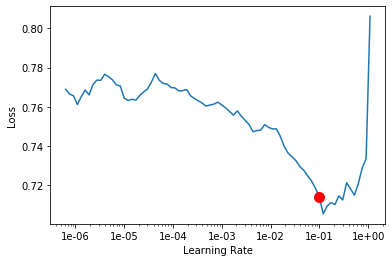

In [22]:
learn.recorder.plot(suggestion=True)

In [23]:
lr = 1e-2
moms = (0.8,0.7)
learn.fit_one_cycle(1,lr,moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.550168,0.542456,0.772064,00:32


In [24]:
learn.save('1a')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 6.31E-08


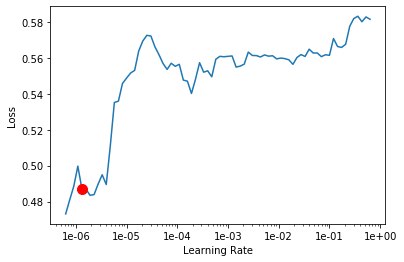

In [25]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [26]:
learn.fit_one_cycle(1,slice(1e-5/(2.6**4),1e-5),moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.554238,0.541220,0.772064,00:48


In [27]:
learn.freeze_to(-3)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.98E-07


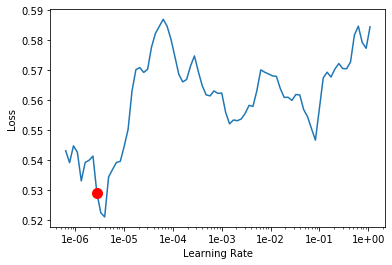

In [28]:
learn.recorder.plot(suggestion=True)

In [29]:
learn.fit_one_cycle(1,slice(3e-7/(2.6**4),3e-7),moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.542039,0.541964,0.772064,00:59


In [30]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 8.32E-05


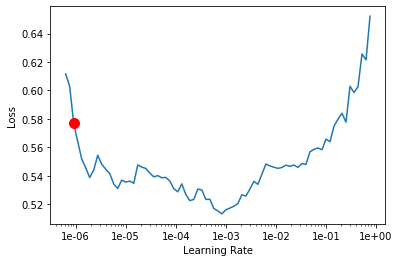

In [31]:
learn.recorder.plot(suggestion=True)

In [32]:
learn.fit_one_cycle(5,slice(3e-5/(2.6**4),3e-5),moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.531352,0.546580,0.772064,01:16
1,0.533833,0.543263,0.772064,01:06
2,0.536354,0.553965,0.772064,01:14
3,0.528774,0.545880,0.772064,01:14
4,0.542263,0.545366,0.772064,01:09
